In [9]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [10]:
def f(x):
    return x **2 + 3
x = np.arange(-2,4,.1)

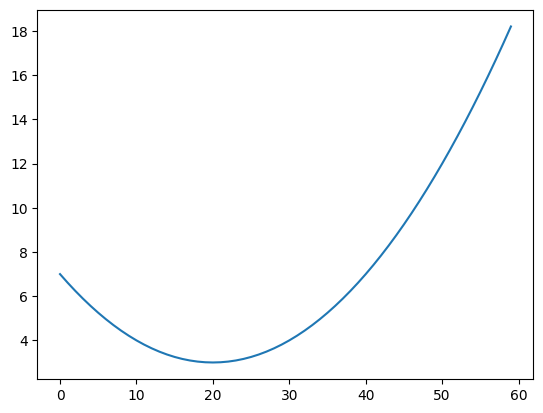

In [11]:
plt.plot(f(x))

In [12]:
a = 2
b = -3
c = 10

f = a*b+c
h = 0.001
b += h
f2 = a*b+c

print(f)
print(f2)

4
4.002


In [13]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._children:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir':'LR'})

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label="{%s|value %.4f| grad %.4f}"%(n._label,n.value,n.grad), shape='record')
        if n._op:
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2))+n2._op)
    return dot

In [69]:
class Node:
    def __init__(self, value, _children=set(), _op=[], grad=0,_label="NOLABEL"):
        self.value = value
        self.grad = 0
        self._backward= lambda : None
        self._label = _label
        self._children = _children
        self._op = _op

    def __repr__(self) -> str:
        return f"Node(value = {self.value})"
    
    def __add__(self, other):
        other = other if isinstance(other, Node) else Node(other)
        out = Node(self.value + other.value, (self, other), '+')
        def _backward():
            self.grad += out.grad * 1.0
            other.grad += out.grad * 1.0
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Node) else Node(other)
        out = Node(self.value * other.value, (self, other), '*')
        def _backward():
            self.grad += out.grad * other.value
            other.grad += out.grad * self.value
        out._backward = _backward
        return out

    def __sub__(self, other):
        other = other if isinstance(other, Node) else Node(other)
        out = Node(self.value - other.value, (self, other), '-')
        def _backward():
            self.grad += out.grad * -1.0
            other.grad += out.grad * 1.0
        out._backward = _backward
        return out 
    
    def __truediv__(self, other):
        other = other if isinstance(other, Node) else Node(other)
        out = Node(self.value / other.value, (self, other), '/')
        # def _backward():
            # self.grad = out.grad * (other.value-)
        return out 
    
    def exp(self):
        out = Node(math.exp(self.value))
        def _backward():
            self.grad += out.grad * out.value
        out._backward = _backward
        return out
    
    
    def tanh(self):
        x = self.value
        out = Node((math.exp(x*2)-1)/(math.exp(x*2)+1), (self, ), 'tanh')
        def _backward():
            self.grad += out.grad * (1-out.value**2)
        out._backward = _backward
        return out
    
    @staticmethod
    def get_topo(node):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._children:
                    build_topo(child)
                topo.append(v)
            return topo
        return build_topo(node)
        
    def backward(self):
        topo_sort = self.get_topo(self)
        self.grad = 1.0
        for node in topo_sort[::-1]:
            node._backward()
    
a = Node(2.0, _label='a')
b = Node(-4.0, _label='b')
c = Node(10, _label='c')
# e = a-b; e._label='e'
# d = e * c; d._label='d'
# f = Node(-2.0, _label='f')
# l = d.exp()
# l

In [70]:
b = a + a

In [63]:
a.grad

0

In [64]:
b.backward()

In [65]:
a.grad

2.718281828459045

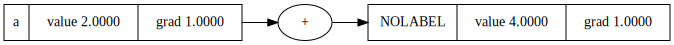

In [73]:
draw_dot(b)

In [72]:
b.backward()

In [6]:
x1 = Node(2.0, _label='x1')
x2 = Node(0.0, _label='x2')

w1 = Node(-3.0, _label='w1')
w2 = Node(1.0, _label='w2')
b = Node(6.8813735870195432, _label='b')

x1w1 = x1*w1; x1w1._label='x1w1'
x2w2 = x2*w2; x2w2._label='x2w2'
x1w1x2w2 = x1w1 + x2w2 ; x1w1x2w2._label='x1w1x2w2'
n = x1w1x2w2 + b; n._label ='n'
# o = n.tanh(); o._label='o'
two = Node(2.0, _label='2')
nn =  two*n
o = ((nn).exp() - 1)
o = o.divide((nn).exp() + 1)
o

AttributeError: 'Node' object has no attribute 'exp'

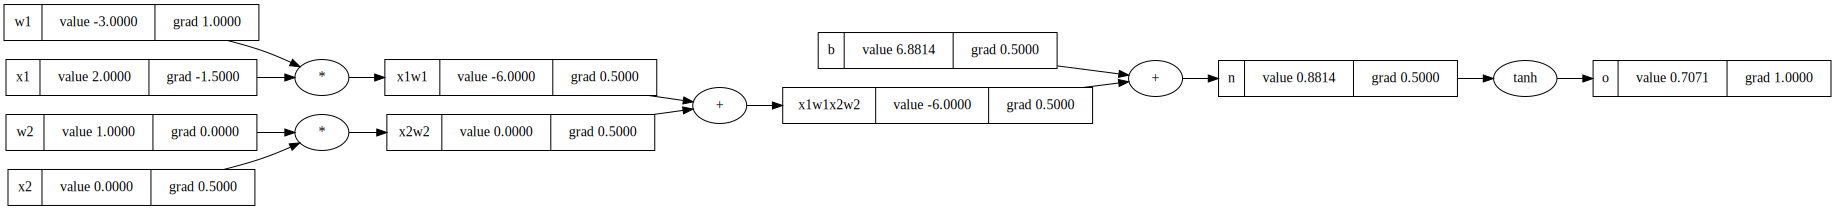

In [112]:
draw_dot(o)

In [111]:
o.backward()

In [102]:
o.grad = 1
o._backward()
n._backward()
x1w1x2w2._backward()
b._backward()
x1w1._backward()
x2w2._backward()
x1._backward()
x2._backward()
w1._backward()
w2._backward()

In [104]:
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._children:
            build_topo(child)
        topo.append(v)
    return topo
build_topo(o)
topo

[Node(value = 2.0),
 Node(value = -3.0),
 Node(value = -6.0),
 Node(value = 0.0),
 Node(value = 1.0),
 Node(value = 0.0),
 Node(value = -6.0),
 Node(value = 6.881373587019543),
 Node(value = 0.8813735870195432),
 Node(value = 0.7071067811865476)]

In [75]:
# o = tanh(n)
# do/do = 1
# do/dn = 1-tanh(n)**2
o.grad = 1

In [76]:
n.grad = 1-(o.value**2)

In [77]:
b.grad = n.grad
x1w1x2w2.grad = n.grad

In [78]:
x1w1.grad = x1w1x2w2.grad
x2w2.grad = x1w1x2w2.grad

In [79]:
w1.grad = x1.value * x1w1.grad 
x1.grad = w1.value * x1w1.grad 


In [80]:
w2.grad = x2.value * x2w2.grad 
x2.grad = w2.value * x2w2.grad 